In [2]:

import numpy
import pandas
import matplotlib.pyplot
import sklearn.neural_network

In [3]:
def preprocessing(folder_name) :
	"""
	Preproccess the raw data for easy/better use
	Input Paramteres :
		file_name_with_relative_path - name of file from which contains data
	Return Values :
		x - features
		y - target value
	"""

	train_df = pandas.read_csv(folder_name + '/mnist_train.csv')
	test_df = pandas.read_csv(folder_name + '/mnist_test.csv')

	data_df = train_df.append(test_df).reset_index(drop = True)
	data_df = data_df.sample(frac = 0.05).reset_index(drop = True)

	y = data_df['label'].to_numpy()
	x = data_df.drop('label', axis = 1).to_numpy()

	y = y.reshape((y.shape[0], -1))

	return (x, y)


In [4]:
def split_dataset(features, target, train_ratio, val_ratio, test_ratio) :
	"""
	Splits the dataset into training, validation and testing
	Input Parameters:
		features - features columns of dataset
		target - target columns of dataset
		train_ratio - the ratio of split for training set
		val_ratio - the ratio of split for validation set
		test_ratio - the ratio of split for testing set
	Return Values:
		train_set - a two tuple containing features and target of training set
		val_set - a two tuple containing features and target of validation set
		test_set - a two tuple containing features and target of testing set
	"""

	enteries_count = features.shape[0]
	train_size = int( enteries_count * train_ratio )
	val_size = int( enteries_count * val_ratio )

	val_index_l = train_size
	val_index_r = train_size + val_size

	indexes = numpy.arange(enteries_count)
	numpy.random.shuffle(indexes)

	# split data into train/test sets
	train_set = (features[indexes[ : train_size]], target[indexes[ : train_size]])
	val_set = (features[indexes[ val_index_l : val_index_r ]], target[indexes[ val_index_l : val_index_r ]])
	test_set = (features[indexes[ val_index_r : ]], target[indexes[ val_index_r : ]])

	# print(features.shape[0], train_set[0].shape[0], val_set[0].shape[0], test_set[0].shape[0])

	return (train_set, val_set, test_set)


In [17]:
class MyNeuralNetwork():

	def __init__(self, n_layers, layer_sizes, activation, learning_rate, weight_init, batch_size, num_epochs):
		"""
		Initialise all class attributes
		Input Parameters -
			n_layers : Number of layers (int)
			layer_sizes : array of size n_layers which contains the number of nodes in each layer (array of int)
			activation : Activation function to be used (string) ['relu', 'leaky relu' 'sigmoid', 'linear', 'tanh', 'softmax']
			learning_rate : the learning rate to be used (float)
			weight_init : initialization function to be used (string) [zero, random, normal]
			batch_size : batch size to be used (int)
			num_epochs : number of epochs to be used (int)
		"""

		self.n_layers = n_layers
		self.layer_sizes = layer_sizes
		self.activation = activation
		self.learning_rate = learning_rate
		self.weight_init = weight_init
		self.batch_size = batch_size
		self.num_epochs = num_epochs

		self.weights = [ self.weight_function((self.layer_sizes[i], self.layer_sizes[i+1])) for i in range(self.n_layers - 1) ]
		self.biases = [ numpy.zeros(self.layer_sizes[i+1]) for i in range(self.n_layers - 1) ]

		self.training_loss = numpy.zeros(self.num_epochs)
		self.validation_loss = numpy.zeros(self.num_epochs)

	def weight_function(self, shape) :
		"""
		Returns a numpy array of given shape with values initialised as per chosen option
		Input Parameters:
			shape - shape of array
		Output Parameters:
			a numpy array of given shape
		"""

		if self.weight_init == "zero" :
			return self.zero_init(shape)
		elif self.weight_init == "random" :
			return self.random_init(shape)
		elif self.weight_init == "normal" :
			return self.normal_init(shape)
		else :
			raise Exception('Incorrect Weight Initialisation Function')

	def zero_init(self, shape) :
		"""
		Generates a numpy array of given shape with all values zero
		Input Parameters:
			shape - shape of array
		Output Parameters:
			weights - a zero filled numpy array of given shape
		"""

		weights = numpy.zeros(shape)

		return weights

	def random_init(self, shape) :
		"""
		Generates a numpy array of given shape filled with random values
		Input Parameters:
			shape - shape of array
		Output Parameters:
			weights - a randomly filled numpy array of given shape
		"""

		scaling_factor = 0.01 
		weights = numpy.random.random_sample(shape) * scaling_factor

		return weights
	
	def normal_init(self, shape) :
		"""
		Generates a numpy array of having normal 
		Input Parameters:
			shape - shape of array
		Output Parameters:
			weights - a randomly filled numpy array of given shape
		"""

		scaling_factor = 0.01
		weights = numpy.random.normal(size = shape) * scaling_factor

		return weights
	
	def activation_fuction_with_derivative(self, v) :
		"""
		Caclculates the activation value and its derivative for given value
		Input Parameters:
			v - value for which activation value and derivative is required
		Output Parameters:
			activation value, activation value's derivative
		"""

		# ['relu', 'leaky relu' 'sigmoid', 'linear', 'tanh', 'softmax']
		if self.activation == "relu" :
			return self.relu(v)
		elif self.activation == "leaky relu" :
			return self.leaky_relu(v)
		elif self.activation == "sigmoid" :
			return self.sigmoid(v)
		elif self.activation == "linear" :
			return self.linear(v)
		elif self.activation == "tanh" :
			return self.tanh(v)
		elif self.activation == "softmax" :
			return self.softmax(v)
		else :
			raise Exception('Incorrect Activation Function')

	def relu(self, v) :
		"""
		Caclculates the relu activation value and its derivative for given value
		Input Parameters:
			v - value for which activation value and derivative is required
		Output Parameters:
			y - relu activation value
			d_phi - derivative of relu activation at v
		"""

		y = numpy.where(v >= 0, v, 0)
		d_phi = numpy.where(v >= 0, 1, 0)

		return (y, d_phi)


	def leaky_relu(self, v) :
		"""
		Caclculates the leaky relu activation value and its derivative for given value
		Input Parameters:
			v - value for which activation value and derivative is required
		Output Parameters:
			y - leaky relu activation value
			d_phi - derivative of leaky relu activation at v
		"""

		alpha = 0.1
		y = numpy.where(v >= 0, v, alpha * v)
		d_phi = numpy.where(v >= 0, 1, alpha)

		return (y, d_phi)

	def sigmoid(self, v) :
		"""
		Caclculates the sigmoid activation value and its derivative for given value
		Input Parameters:
			v - value for which activation value and derivative is required
		Output Parameters:
			y - sigmoid activation value
			d_phi - derivative of sigmoid activation at v
		"""

		y = 1 / (1 + numpy.exp(-v))
		d_phi = y * (1 - y)

		return (y, d_phi)

	def linear(self, v) :
		"""
		Caclculates the linear activation value and its derivative for given value
		Input Parameters:
			v - value for which activation value and derivative is required
		Output Parameters:
			y - linear activation value
			d_phi - derivative of linear activation at v
		"""

		y = v
		d_phi = numpy.ones(v.shape)

		return (y, d_phi)

	def tanh(self, v) :
		"""
		Caclculates the tanh activation value and its derivative for given value
		Input Parameters:
			v - value for which activation value and derivative is required
		Output Parameters:
			y - tanh activation value
			d_phi - derivative of tanh activation at v
		"""

		y = numpy.tanh(v)
		d_phi = 1 - numpy.square(y)
		
		return (y, d_phi)

	def softmax(self, v) :
		"""
		Caclculates the tanh activation value and its derivative for given value
		Input Parameters:
			v - value for which activation value and derivative is required
		Output Parameters:
			y - softmax activation value
			d_phi - derivative of softmax activation at v
		"""

		v -= numpy.max(v)
		t = numpy.exp(v)
		y = t / ( t.sum(axis=1, keepdims = True) )

		d_phi = None

		return (y, d_phi)

	def cross_entropy_loss(self, y_true, y_pred_prob):
		"""
		Calculates the cross entropy loss from true target and calculated probabilites of predictions
		Input Parameters:
			y_true - true values of targets
			y_pred_prob - probability of predicitions
		Output Parameters:
			loss - calculated cross entropy loss
		"""

		sum_score = 10**(-9)
        
		for i in range(y_true.shape[0]):
			sum_score += y_true[i] * numpy.log( 1e-15  +  y_pred_prob[i])
		loss = 1.0 / y_true.shape[0] * sum_score

		return loss

	def fit(self, train_set, val_set = None):
		"""
		Fits the model using given training data
		Input Parameters:
			train_set - training data, a tuple of features and target
			val_set - validation data, a tuple of features and target
		Output Parameters:
			None
		"""

		indexes = numpy.arange(train_set[0].shape[0])
		for e in range(self.num_epochs) :
		
			choosen_indexes = numpy.random.choice(indexes, size = self.batch_size, replace = False)
			x_batch = train_set[0][choosen_indexes]
			y_batch = train_set[1][choosen_indexes]

			output_values, activation_outputs = self.forward_propagation(x_batch)
			local_graidents = self.backward_propagation(y_batch, output_values, activation_outputs)

			self.weights[0] -= self.learning_rate * (x_batch.T.dot(local_graidents[0]))
			for l in range(1, self.n_layers-1):
				delta_weight = (1/x_batch.shape[0]) * self.learning_rate * activation_outputs[l - 1].T.dot(local_graidents[l])
				self.weights[l] -= delta_weight
				delta_bias = (1/x_batch.shape[0]) * self.learning_rate * numpy.sum(local_graidents[l])
				self.biases[l] -= delta_bias

			if val_set is None :
				y_val_pred_prob=self.predict_prob(val_set[0])
				val_cost=self.cross_entropy_loss(y_val_pred_prob, val_set[1])
			train_cost = self.cross_entropy_loss(activation_outputs[self.n_layers - 2], train_set[1])

			self.training_loss[e] = train_cost
			if val_set is None :
				self.validation_loss[e] = val_cost

	def forward_propagation(self, x) :
		"""
		Performs the forward phase
		Input Parameters:
			x - inputs
		Output Parameters:
			outputs - output values of each layer
			activations - output values of each layer after performing activation
		"""

		outputs = []
		activations = []
		for l in range(self.n_layers - 2) :
			hidden_output = x.dot(self.weights[l]) + self.biases[l]
			hidden_activation_output, _ = self.activation_fuction_with_derivative(hidden_output)

			x = hidden_activation_output
			outputs.append(hidden_output)
			activations.append(hidden_activation_output)

		final_output = x.dot(self.weights[self.n_layers - 2]) + self.biases[self.n_layers - 2]
		final_activation_output, _ = self.softmax(final_output)
		outputs.append(final_output)
		activations.append(final_activation_output)

		return outputs, activations

	def backward_propagation(self, y_true, outputs, activation_outputs) :
		"""
		Performs the backward phase
		Input Parameters:
			y_true - true targets
			v - outputs after each layer
			y - outputs after performing activations
		Output Parameters:
			local_gradients : local gradients for each layer
		"""

		local_gradients = {}
		last_layer_gradient = activation_outputs[self.n_layers - 2] - y_true
		local_gradients[self.n_layers - 2] = last_layer_gradient

		for l in range(self.n_layers - 3, -1, -1) :
			next_layer_error = local_gradients[l + 1].dot(self.weights[l + 1].T)
			_, derivative = self.activation_fuction_with_derivative(outputs[l])
			local_gradients[l] = next_layer_error * derivative

		return local_gradients

	def predict_proba(self, x) :
		"""
		Predicts probabilities of targets for given features
		Input Parameters :
			x - features for which targets probabilities are needed
		Output Parameters:
			probs - calculated probabilities
		"""
		
		probs, _ = self.forward_propagation(x)

		return probs[self.n_layers - 2]

	def predict(self, x) :
		"""
		Predict targets for given features
		Input Parameters :
			x - features for which targets are needed
		Output Parameters:
			y - calculated targets
		"""
		
		prob = self.predict_proba(x)
		y = prob.argmax(axis = 1)

		return y

	def score(self, x, y) :
		"""
		Calculates the score (accuracy) of the model
		Input Parameters :
			x - features for which targets are needed
			y - actual targets
		Output Parameters :
			accuracy - accuracy of the model on the provided features and targets
		"""

		y_pred = self.predict(x)
		accuracy = (y == y_pred).mean()

		return accuracy

	def plot_losses(self) :
		"""
		Plot losses from calculated training (and validation) losses
		Input Parameters:
			None
		Output Parameters:
			None
		"""

		matplotlib.pyplot.plot(self.training_loss, label = 'Training')
		matplotlib.pyplot.plot(self.validation_loss, label = 'Validation')
		matplotlib.pyplot.legend()
		matplotlib.pyplot.grid(True)
		matplotlib.pyplot.ylabel("Error")
		matplotlib.pyplot.xlabel("Epochs")
		matplotlib.pyplot.rc('axes', labelsize = 20)
		title_text = "Training and Validation Erros vs Epochs" + "\nfor alpha = " + str(self.learning_rate) + ", activation = " + self.activation + " and weight init = " + self.weight_init
		matplotlib.pyplot.title(title_text, fontsize = 14)
		save_name = "l=" + str(self.learning_rate) +"_" + "a=" + self.activation + "_" + "w=" + self.weight_init
		matplotlib.pyplot.savefig("Plots/Q2/" + save_name + ".jpg")
		matplotlib.pyplot.show()


In [6]:

def sklearns(layers, learning_rate, epochs, train_set, test_set, type, name) :
	"""
	Performs Multilayer Perceptron using sklearn
	Input Parameters:
		layers - layer sizes
		learning_rate - learning rate for model
		epochs - number of iterations
		train_set - training set
		test_set - testing set
		type - type of activation function to use
		name - name of activation function used
	"""
	model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=layers[1:-1], solver='sgd', activation=type, learning_rate='constant', learning_rate_init=learning_rate, max_iter=epochs)
	model.fit(train_set[0], numpy.ravel(train_set[1]))
	train_acc = model.score(train_set[0], numpy.ravel(train_set[1]))
	test_acc = model.score(test_set[0], numpy.ravel(test_set[1]))
	print(name, ":", "Training accuracy:", train_acc, "Testing accuracy:", test_acc)


In [7]:

folder_name = "Datasets/Q2"
x, y = preprocessing(folder_name)


In [8]:
train_set, val_set, test_set = split_dataset(x, y, 0.7, 0.2, 0.1)


In [9]:
layers = [784, 256, 128, 64, 32, 1]
n_layers = len(layers)
activation = 'tanh'
learning_rate = 0.08
weight_init = 'normal'
batch_size = train_set[0].shape[0] // 20
epochs = 150

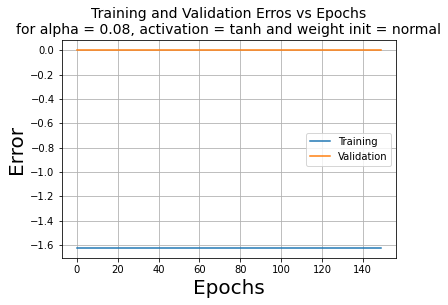

Testing Accuracy :  0.12


In [18]:

model = MyNeuralNetwork(n_layers, layers, activation, learning_rate, weight_init, batch_size, epochs)
model.fit(train_set, val_set)
model.plot_losses()
testing_accuracy = model.score(test_set[0], test_set[1])

print("Testing Accuracy : ", testing_accuracy)

In [11]:
print(x.shape, y.shape)

(3500, 784) (3500, 1)


In [19]:
solvers = [('relu', 'RELU'), ('identity', 'Linear'), ('logistic', 'Sigmoid'), ('tanh', 'tanh')]
for s in solvers:
	sklearns(layers, learning_rate, epochs, train_set, test_set, s[0], s[1])

RELU : Training accuracy: 0.10612244897959183 Testing accuracy: 0.11428571428571428


C:\Program Files\Python39\lib\site-packages\sklearn\utils\extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Program Files\Python39\lib\site-packages\sklearn\utils\extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
C:\Program Files\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


Linear : Training accuracy: 0.09959183673469388 Testing accuracy: 0.12
Sigmoid : Training accuracy: 0.5346938775510204 Testing accuracy: 0.49714285714285716
tanh : Training accuracy: 0.09673469387755101 Testing accuracy: 0.06857142857142857
